In [1]:
import os
import sys
from typing import Optional, Union, Tuple, List, Callable, Dict, Any
import torch
from pathlib import Path
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch.nn.functional as nnf
from torchvision.utils import save_image
import safetensors.torch
import numpy as np
import abc
import ptp_utils_ella
import seq_aligner
from PIL import Image
from IPython.display import display

from ella_model import ELLA, T5TextEmbedder


In [2]:
# P2P
LOW_RESOURCE = False 
NUM_DIFFUSION_STEPS = 70
GUIDANCE_SCALE = 11
MAX_NUM_WORDS = 64

# ELLA
ELLA_PATH = "D:/Projects/Upenn_ESE_6450/FinalProject/ella/ella-sd1.5-tsc-t5xl.safetensors"
CUSTOM_CACHE_DIR = 'D:/Models'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
class ELLAProxyUNet(torch.nn.Module):
    def __init__(self, ella, unet):
        super().__init__()
        self.ella = ella
        self.unet = unet
        self.config = unet.config
        self.dtype = unet.dtype
        self.device = unet.device
        self.flexible_max_length_workaround = None
        # self.counter = 0

    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[dict[str, Any]] = None,
        added_cond_kwargs: Optional[dict[str, torch.Tensor]] = None,
        down_block_additional_residuals: Optional[tuple[torch.Tensor]] = None,
        mid_block_additional_residual: Optional[torch.Tensor] = None,
        down_intrablock_additional_residuals: Optional[tuple[torch.Tensor]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        return_dict: bool = True,
    ):
        # print(f"{self.counter} sample {sample.shape}")
        # print(f"{self.counter} timestep {timestep}")
        # print(f"{self.counter} encoder_hidden_states {encoder_hidden_states.shape}")
        if self.flexible_max_length_workaround is not None:
            time_aware_encoder_hidden_state_list = []
            for i, max_length in enumerate(self.flexible_max_length_workaround):
                time_aware_encoder_hidden_state_list.append(
                    self.ella(encoder_hidden_states[i : i + 1, :max_length], timestep)
                )
            # print(f"{self.counter} time_aware_encoder_hidden_state_list {len(time_aware_encoder_hidden_state_list)}")
            # print(f"{self.counter} each dimension {time_aware_encoder_hidden_state_list[0].shape}")
            time_aware_encoder_hidden_states = torch.cat(
                time_aware_encoder_hidden_state_list, dim=0
            )
            # print(f"{self.counter} time_aware_encoder_hidden_states final {time_aware_encoder_hidden_states.shape}")
        else:
            time_aware_encoder_hidden_states = self.ella(
                encoder_hidden_states, timestep
            )
            # print(f"{self.counter} time_aware_encoder_hidden_states final {time_aware_encoder_hidden_states.shape} in other case")

        # self.counter += 1

        return self.unet(
            sample=sample,
            timestep=timestep,
            encoder_hidden_states=time_aware_encoder_hidden_states,
            class_labels=class_labels,
            timestep_cond=timestep_cond,
            attention_mask=attention_mask,
            cross_attention_kwargs=cross_attention_kwargs,
            added_cond_kwargs=added_cond_kwargs,
            down_block_additional_residuals=down_block_additional_residuals,
            mid_block_additional_residual=mid_block_additional_residual,
            down_intrablock_additional_residuals=down_intrablock_additional_residuals,
            encoder_attention_mask=encoder_attention_mask,
            return_dict=return_dict,
        )

def load_ella(filename, device, dtype):
    ella = ELLA()
    safetensors.torch.load_model(ella, filename, strict=True)
    ella.to(device, dtype=dtype)
    return ella

def load_ella_for_pipe(pipe, ella):
    pipe.unet = ELLAProxyUNet(ella, pipe.unet)

def offload_ella_for_pipe(pipe):
    pipe.unet = pipe.unet.unet

In [4]:
# Initiate SD 1.5
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    feature_extractor=None,
    requires_safety_checker=False,
    cache_dir=CUSTOM_CACHE_DIR
).to(device)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Initiate ELLA
ella = load_ella(ELLA_PATH, device, pipe.dtype)
t5_encoder = T5TextEmbedder().to(device, dtype=torch.float16)
tokenizer = pipe.tokenizer

g_cpu = torch.Generator().manual_seed(8888)
#load_ella_for_pipe(pipe, ella)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
class LocalBlend:

    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=.3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils_ella.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold


class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn
    
    
class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

        
class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils_ella.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)
        

class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils_ella.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer

In [6]:
sp = 'test/y1.png'
prompts = ["Crocodile in a sweater"]
controller = AttentionStore()
load_ella_for_pipe(pipe, ella)
images = ptp_utils_ella.text2image_ldm_stable_pure_ella(pipe, t5_encoder, prompts, controller, device, latent=None, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=torch.Generator(device="cuda").manual_seed(1001), low_resource=LOW_RESOURCE)
offload_ella_for_pipe(pipe)
save_image(images, sp)

prompt_embeds torch.Size([1, 256, 2048])
negative_prompt_embeds torch.Size([1, 256, 2048])
directly return


  0%|          | 0/70 [00:00<?, ?it/s]

In [7]:
sp = 'test/y2.png'
prompts = ["Crocodile in a sweater"]
controller = AttentionStore()
load_ella_for_pipe(pipe, ella)
images, _ = ptp_utils_ella.text2image_ldm_stable(pipe, t5_encoder, prompts, controller, device, latent=None, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=torch.Generator(device="cuda").manual_seed(1001), low_resource=LOW_RESOURCE)
offload_ella_for_pipe(pipe)
image = Image.fromarray(images[0])
image.save(sp)

prompt_embeds torch.Size([1, 256, 2048])
negative_prompt_embeds torch.Size([1, 256, 2048])
context torch.Size([2, 256, 2048])
initialized latent torch.Size([1, 4, 64, 64])
expanded latents torch.Size([1, 4, 64, 64])


d:\Projects\Upenn_ESE_6450\FinalProject\P2P\prompt-to-prompt\ptp_utils_ella.py:126: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.unet.in_channels, height // 8, width // 8),
d:\Projects\Upenn_ESE_6450\FinalProject\P2P\prompt-to-prompt\ptp_utils_ella.py:129: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size, model.unet.unet.in_channels, height // 8, width // 8).to(model.device)


  0%|          | 0/70 [00:00<?, ?it/s]

In [8]:
def run_and_display(model, encoder, prompts, controller, device, latent=None, run_baseline=False, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(model, encoder, prompts, EmptyControl(), device, latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = ptp_utils_ella.text2image_ldm_stable(model, encoder, prompts, controller, device, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    ptp_utils_ella.view_images(images)
    return images, x_t
g_gpu = torch.Generator(device="cuda").manual_seed(1001)

prompt_embeds torch.Size([1, 256, 2048])
negative_prompt_embeds torch.Size([1, 256, 2048])
context torch.Size([2, 256, 2048])
initialized latent torch.Size([1, 4, 64, 64])
expanded latents torch.Size([1, 4, 64, 64])


  0%|          | 0/70 [00:00<?, ?it/s]

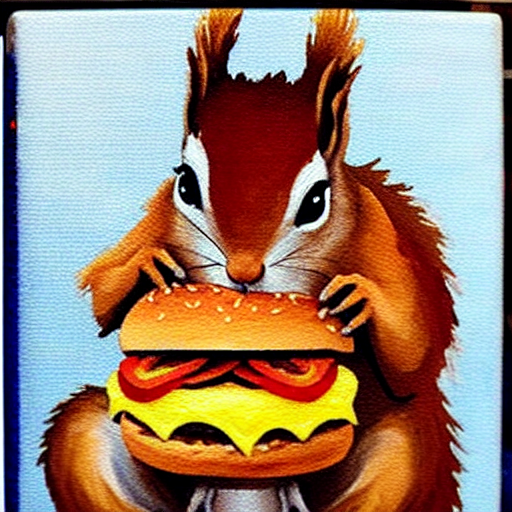

In [9]:
prompts = ["A painting of a squirrel eating a burger"]
controller = AttentionStore()
load_ella_for_pipe(pipe, ella)
image, x_t = run_and_display(pipe, t5_encoder, prompts, controller, device, latent=None, run_baseline=False, generator=g_gpu)
offload_ella_for_pipe(pipe)

w.o. prompt-to-prompt
prompt_embeds torch.Size([2, 256, 2048])
negative_prompt_embeds torch.Size([2, 256, 2048])
context torch.Size([4, 256, 2048])
initialized latent torch.Size([1, 4, 64, 64])
expanded latents torch.Size([2, 4, 64, 64])


  0%|          | 0/70 [00:00<?, ?it/s]

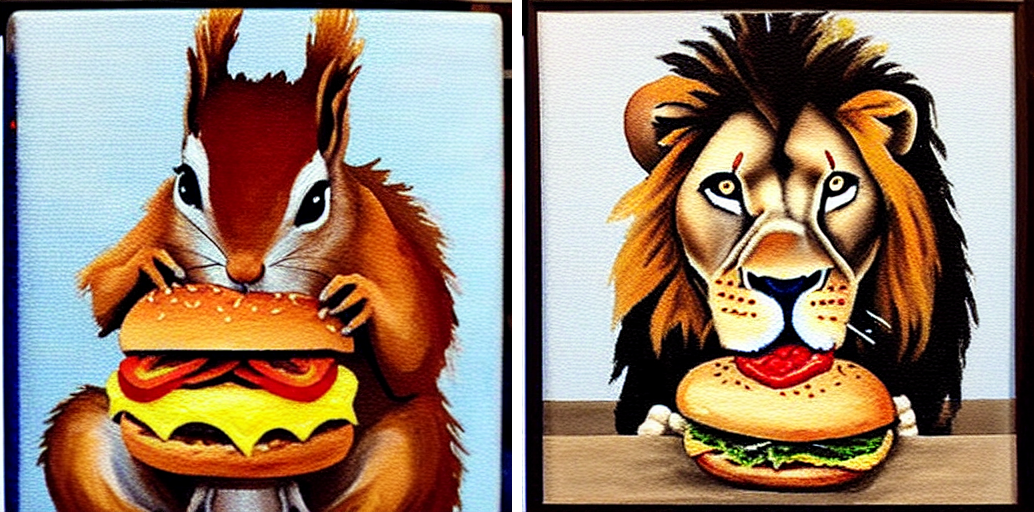

with prompt-to-prompt
prompt_embeds torch.Size([2, 256, 2048])
negative_prompt_embeds torch.Size([2, 256, 2048])
context torch.Size([4, 256, 2048])
initialized latent torch.Size([1, 4, 64, 64])
expanded latents torch.Size([2, 4, 64, 64])


  0%|          | 0/70 [00:00<?, ?it/s]

RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [8, 4096, 64]->[1, 8, 4096, 1, 64] [1, 77, 77]->[1, 1, 1, 77, 77]

In [10]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a lion eating a burger"]

controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=0.4)
load_ella_for_pipe(pipe, ella)
_ = run_and_display(pipe, t5_encoder, prompts, controller, device, latent=x_t, run_baseline=True)
offload_ella_for_pipe(pipe)